# Phase 1: Data Preparation

**Flow**: EDA → Parsing → Profiling → Cleaning → Validation → Export

We have 20K+ JSON files from Scopus. Let's turn them into clean, structured data.

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

sns.set_style('whitegrid')
%matplotlib inline

## 1. EDA - Quick Sample

Sample a few files to understand the JSON structure

In [2]:
raw_data_path = Path('../raw_data')

# Check what we have
years = sorted([d.name for d in raw_data_path.iterdir() if d.is_dir()])
print(f"Years: {years}")

for year in years:
    count = len(list((raw_data_path / year).iterdir()))
    print(f"{year}: {count:,} files")

total = sum(len(list((raw_data_path / y).iterdir())) for y in years)
print(f"\nTotal: {total:,} files")

Years: ['2018', '2019', '2020', '2021', '2022', '2023']
2018: 2,792 files
2019: 3,082 files
2020: 3,393 files
2021: 3,815 files
2022: 4,244 files
2023: 2,890 files

Total: 20,216 files


In [3]:
# Open one file to see structure
sample_file = list((raw_data_path / '2020').iterdir())[10]  # Skip first few in case they're weird
print(f"Sample: {sample_file.name}\n")

with open(sample_file, 'r', encoding='utf-8') as f:
    sample = json.load(f)

# Show structure (top-level keys)
print("Top-level keys:")
for key in sample.keys():
    print(f"  - {key}")

Sample: 202000010

Top-level keys:
  - abstracts-retrieval-response


In [4]:
# Navigate to actual data (Scopus wraps everything in 'abstracts-retrieval-response')
if 'abstracts-retrieval-response' in sample:
    resp = sample['abstracts-retrieval-response']
    
    # Data is in 'coredata', not 'item'
    coredata = resp.get('coredata', {})
    authors = resp.get('authors', {})
    
    print("Key fields we need:")
    print(f"  Title: {coredata.get('dc:title', 'N/A')[:80]}...")
    print(f"  Abstract: {coredata.get('dc:description', 'N/A')[:100]}...")
    print(f"  Year: {coredata.get('prism:coverDate', 'N/A')}")
    print(f"  Citations: {coredata.get('citedby-count', 'N/A')}")
    print(f"  Authors: {len(authors.get('author', []))}")

Key fields we need:
  Title: Biomarker-guided preemption of steroid-refractory graft-versus-host disease with...
  Abstract: Steroid-refractory (SR) acute graft-versus-host disease (GVHD) remains a major cause of nonrelapse m...
  Year: 2020-12-22
  Citations: 18
  Authors: 29


**Summary**: JSON has wrapper → coredata contains fields, authors separate

## 2. Data Parsing

Parse all 20K+ JSON files into DataFrame

In [5]:
def parse_paper(file_path):
    """
    Extract fields from one JSON file
    Returns dict or None if should skip
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Navigate to response
        if 'abstracts-retrieval-response' not in data:
            return None
        
        resp = data['abstracts-retrieval-response']
        
        # Get coredata and authors
        coredata = resp.get('coredata', {})
        if not coredata:
            return None
        
        authors_data = resp.get('authors', {})
        affiliation_data = resp.get('affiliation', [])
        
        # Extract fields from coredata
        title = coredata.get('dc:title', '')
        abstract = coredata.get('dc:description', '')
        
        # Skip if no abstract (can't search without text)
        if not abstract or len(abstract.strip()) < 50:  # At least 50 chars
            return None
        
        # Parse year from prism:coverDate
        date_str = coredata.get('prism:coverDate', '')
        year = extract_year(date_str)
        if not year or year < 2018 or year > 2023:
            return None
        
        # Citations
        citations = coredata.get('citedby-count', 0)
        try:
            citations = int(citations)
        except:
            citations = 0
        
        # Authors
        authors = extract_authors(authors_data.get('author', []))
        
        # Affiliations
        affiliations = extract_affiliations(affiliation_data)
        
        # References (FIXED: correct path to itemid)
        item = resp.get('item', {})
        bibrecord = item.get('bibrecord', {}) if item else {}
        tail = bibrecord.get('tail', {}) if bibrecord else {}
        bibliography = tail.get('bibliography', {}) if tail else {}
        references = extract_references(bibliography.get('reference', []))
        
        # IDs
        doi = coredata.get('prism:doi', '')
        scopus_id = coredata.get('dc:identifier', '').replace('SCOPUS_ID:', '')
        eid = coredata.get('eid', '')
        
        return {
            'id': file_path.stem,
            'scopus_id': scopus_id or eid,
            'doi': doi,
            'title': clean_text(title),
            'abstract': clean_text(abstract),
            'year': year,
            'citation_count': citations,
            'authors': authors,
            'affiliations': affiliations,
            'references': references
        }
        
    except Exception as e:
        return None

def extract_year(date_str):
    """Extract 4-digit year from date string"""
    if not date_str:
        return None
    match = re.search(r'(20\d{2})', str(date_str))
    return int(match.group(1)) if match else None

def extract_authors(author_list):
    """Extract author names, semicolon-separated"""
    if not author_list:
        return ''
    names = []
    for author in author_list:
        if isinstance(author, dict):
            name = author.get('ce:indexed-name', '') or author.get('ce:surname', '') or author.get('preferred-name', {}).get('ce:indexed-name', '')
            if name:
                names.append(name)
    return ';'.join(names)

def extract_affiliations(affil_list):
    """Extract affiliation names"""
    if not affil_list:
        return ''
    affils = []
    for affil in affil_list:
        if isinstance(affil, dict):
            name = affil.get('affilname', '')
            if name:
                affils.append(name)
    return ';'.join(affils)

def extract_references(ref_list):
    """Extract reference IDs for citation network"""
    if not ref_list:
        return ''
    refs = []
    for ref in ref_list:
        if isinstance(ref, dict):
            # FIXED: Navigate to correct location
            ref_info = ref.get('ref-info', {})
            if ref_info:
                itemidlist = ref_info.get('refd-itemidlist', {})
                if itemidlist:
                    itemid = itemidlist.get('itemid', {})
                    if isinstance(itemid, dict):
                        ref_id = itemid.get('$', '')
                        if ref_id:
                            refs.append(str(ref_id))
    return ';'.join(refs)

def clean_text(text):
    """Remove extra whitespace and special chars"""
    if not text:
        return ''
    text = ' '.join(text.split())
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    return text.strip()

In [6]:
# Test parser on sample file
test = parse_paper(sample_file)
if test:
    print("Parser works!\n")
    for k, v in test.items():
        if isinstance(v, str) and len(v) > 100:
            print(f"{k}: {v[:100]}...")
        else:
            print(f"{k}: {v}")
else:
    print("Sample was skipped (no abstract or bad year)")

Parser works!

id: 202000010
scopus_id: 85098074752
doi: 10.1182/bloodadvances.2020003336
title: Biomarker-guided preemption of steroid-refractory graft-versus-host disease with a-1-antitrypsin
abstract: Steroid-refractory (SR) acute graft-versus-host disease (GVHD) remains a major cause of nonrelapse m...
year: 2020
citation_count: 18
authors: Gergoudis S.C.;DeFilipp Z.;Ozbek U.;Sandhu K.S.;Etra A.M.;Choe H.K.;Kitko C.L.;Ayuk F.;Aziz M.;Baez ...
affiliations: Icahn School of Medicine at Mount Sinai;Vanderbilt University Medical Center;Universitätsklinikum Er...
references: 65349171937;85038445316;84952639589;85048708977;2342471922;69849102119;85015326054;84954064873;85038...


### Parse all files (this takes 20-30 minutes)

In [7]:
# Checkpoint: Check if already parsed
output_file = Path('../data/processed/papers.parquet')

if output_file.exists():
    print("Found existing parquet file!")
    print("Loading from disk (fast)...")
    df = pd.read_parquet(output_file)
    print(f"Loaded {len(df):,} papers in {df.shape[1]} columns")
    print("\nSkip to Section 3 (Profiling) or re-run parsing below.")
else:
    print("No existing file found. Will parse from scratch below.")

Found existing parquet file!
Loading from disk (fast)...
Loaded 19,523 papers in 13 columns

Skip to Section 3 (Profiling) or re-run parsing below.


In [8]:
# Parse all files (run this if no parquet exists or want to re-parse)
all_papers = []
skipped = 0

print("Parsing all JSON files...\n")

for year in years:
    year_path = raw_data_path / year
    files = list(year_path.iterdir())
    
    print(f"Processing {year}: {len(files)} files")
    
    for file in tqdm(files, desc=year):
        parsed = parse_paper(file)
        if parsed:
            all_papers.append(parsed)
        else:
            skipped += 1

print(f"\nParsed: {len(all_papers):,} papers")
print(f"Skipped: {skipped:,} (no abstract or invalid)")

# Convert to DataFrame
df = pd.DataFrame(all_papers)
print(f"\nDataFrame shape: {df.shape}")

Parsing all JSON files...

Processing 2018: 2792 files


2018: 100%|██████████| 2792/2792 [01:31<00:00, 30.41it/s]


Processing 2019: 3082 files


2019:  51%|█████     | 1567/3082 [00:51<00:49, 30.66it/s]


KeyboardInterrupt: 

## 3. Data Profiling

Use pandas to understand what we have

In [ ]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19550 entries, 0 to 19549
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              19550 non-null  object
 1   scopus_id       19550 non-null  object
 2   doi             19550 non-null  object
 3   title           19550 non-null  object
 4   abstract        19550 non-null  object
 5   year            19550 non-null  int64 
 6   citation_count  19550 non-null  int64 
 7   authors         19550 non-null  object
 8   affiliations    19550 non-null  object
 9   references      19550 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.5+ MB


In [ ]:
# Statistical summary
df.describe()

,year,citation_count,abstract_length,num_authors,num_references
count,19523.000000,19523.000000,19523.000000,19523.000000,19523.000000
mean,2020.611381,9.472315,1410.788301,68.738411,15.236746
std,1.627052,27.527531,466.071866,375.016198,28.591696
min,2018.000000,0.000000,72.000000,1.000000,0.000000
25%,2019.000000,0.000000,1103.000000,3.000000,0.000000
50%,2021.000000,3.000000,1398.000000,5.000000,0.000000
75%,2022.000000,9.000000,1697.000000,7.000000,23.000000
max,2023.000000,1356.000000,10701.000000,5246.000000,1066.000000


In [ ]:
# Check first few rows
df.head()

,id,scopus_id,doi,title,abstract,year,citation_count,authors,affiliations,references,abstract_length,num_authors,num_references
0,201800001,85060936020,10.23919/PIERS.2018.8597669,Flexible Printed Active Antenna for Digital Te...,This paper presents the development of a flexi...,2018,1,Pratumsiri T.;Janpugdee P.,,85006043726;85046336244;85060914424;85046368249,1199,2,4
1,201800002,85052201238,10.1016/j.ces.2018.08.042,Parametric study of hydrogen production via so...,Computational fluid dynamics was applied for s...,2018,21,Phuakpunk K.;Chalermsinsuwan B.;Putivisutisak ...,,,957,4,0
2,201800003,85051498032,10.1016/j.apsusc.2018.08.059,Superhydrophobic coating from fluoroalkylsilan...,A superhydrophobic/superoleophilic mesh was su...,2018,37,Saengkaew J.;Le D.;Samart C.;Sawada H.;Nishida...,Hirosaki University;Chulalongkorn University;T...,,1082,8,0
3,201800004,85050678366,10.1016/j.aca.2018.07.045,Electrochemical impedance-based DNA sensor usi...,A label-free electrochemical DNA sensor based ...,2018,68,Teengam P.;Siangproh W.;Tuantranont A.;Vilaiva...,Chulalongkorn University;Thailand National Ele...,,1668,6,0
4,201800005,85059846549,10.17512/pjms.2018.18.2.24,Evaluation of outsourcing transportation contr...,This paper aims to develop an approach to iden...,2018,15,Setamanit S.-O.,,54349103890;0033235290;69649096182;85043470598...,884,1,20


In [ ]:
# Missing values
print("Missing values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
pd.DataFrame({'Count': missing, 'Percent': missing_pct}).sort_values('Count', ascending=False)

Missing values:


,Count,Percent
id,0,0.0
scopus_id,0,0.0
doi,0,0.0
title,0,0.0
abstract,0,0.0
year,0,0.0
citation_count,0,0.0
authors,0,0.0
affiliations,0,0.0
references,0,0.0


In [ ]:
# Empty strings (different from NULL)
print("Empty string counts:")
for col in ['doi', 'authors', 'affiliations', 'references']:
    empty = (df[col] == '').sum()
    print(f"{col}: {empty:,} ({empty/len(df)*100:.1f}%)")

Empty string counts:
doi: 1,087 (5.6%)
authors: 0 (0.0%)
affiliations: 4,432 (22.7%)
references: 9,938 (50.9%)


Papers by year:
year
2018    2686
2019    2984
2020    3286
2021    3692
2022    4104
2023    2798
Name: count, dtype: int64


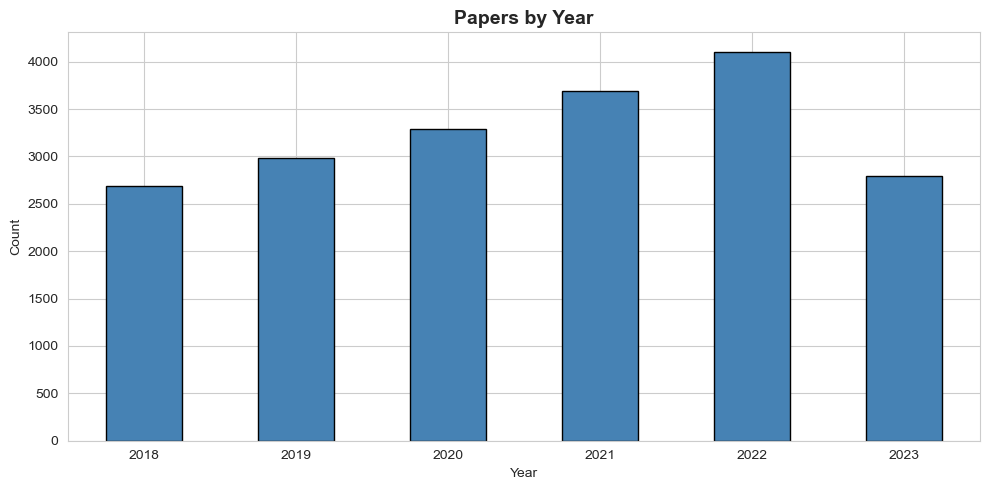

In [ ]:
# Distribution by year
year_counts = df['year'].value_counts().sort_index()
print("Papers by year:")
print(year_counts)

# Visualize
plt.figure(figsize=(10, 5))
year_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Papers by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

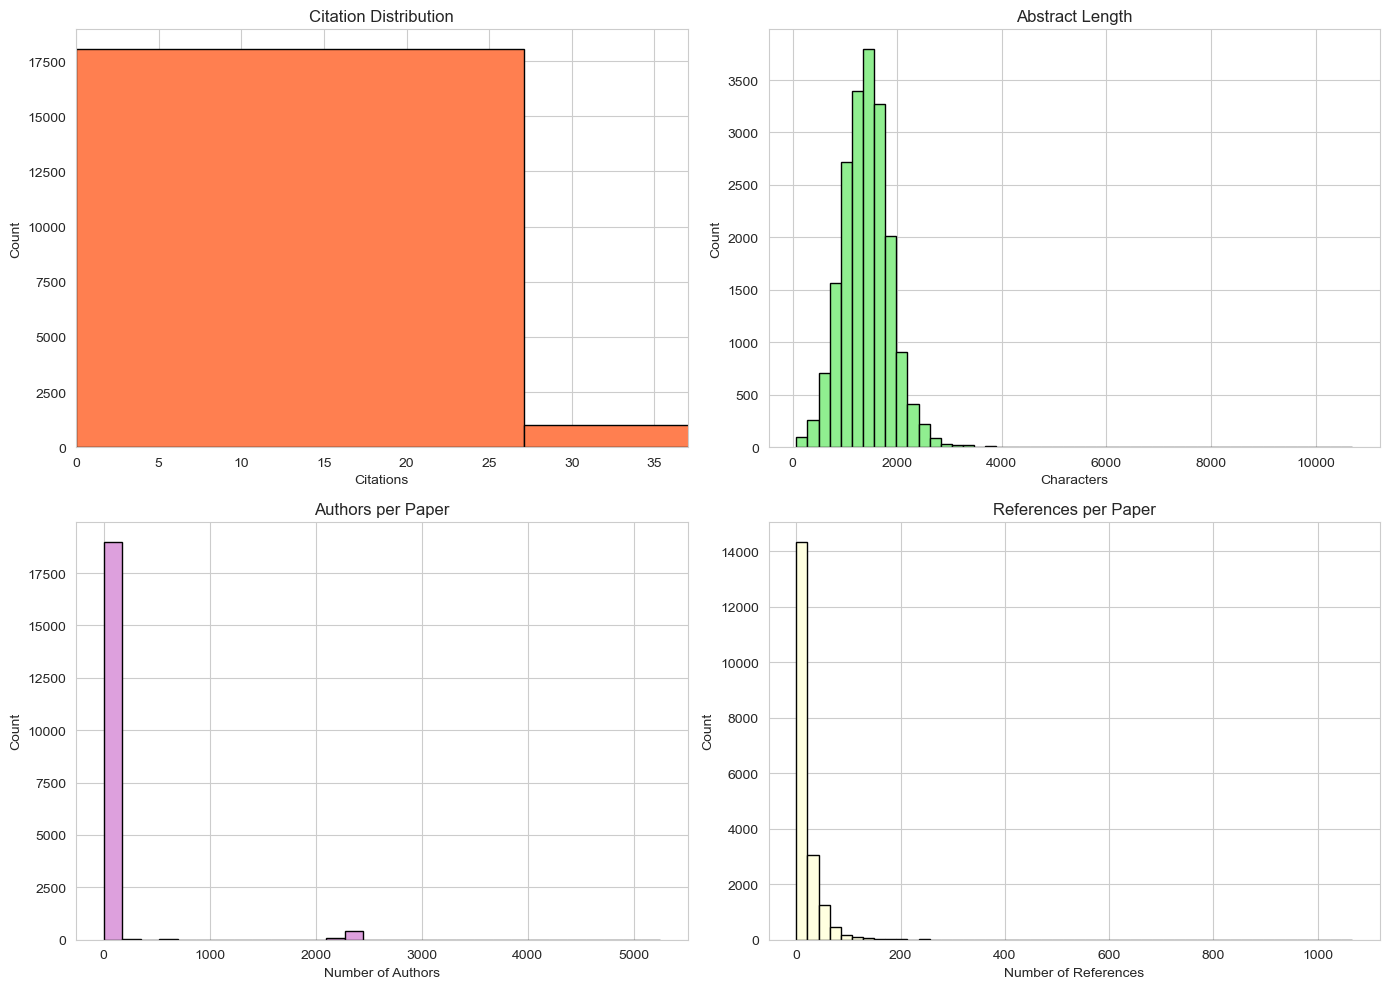

In [ ]:
# Citation distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Citations
axes[0, 0].hist(df['citation_count'], bins=50, color='coral', edgecolor='black')
axes[0, 0].set_title('Citation Distribution')
axes[0, 0].set_xlabel('Citations')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlim(0, df['citation_count'].quantile(0.95))

# Abstract length
df['abstract_length'] = df['abstract'].str.len()
axes[0, 1].hist(df['abstract_length'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Abstract Length')
axes[0, 1].set_xlabel('Characters')
axes[0, 1].set_ylabel('Count')

# Author count
df['num_authors'] = df['authors'].str.count(';') + 1
df.loc[df['authors'] == '', 'num_authors'] = 0
axes[1, 0].hist(df['num_authors'], bins=30, color='plum', edgecolor='black')
axes[1, 0].set_title('Authors per Paper')
axes[1, 0].set_xlabel('Number of Authors')
axes[1, 0].set_ylabel('Count')

# Reference count
df['num_references'] = df['references'].str.count(';') + 1
df.loc[df['references'] == '', 'num_references'] = 0
axes[1, 1].hist(df['num_references'], bins=50, color='lightyellow', edgecolor='black')
axes[1, 1].set_title('References per Paper')
axes[1, 1].set_xlabel('Number of References')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# Key statistics
print("=" * 60)
print("DATA PROFILE SUMMARY")
print("=" * 60)
print(f"Total papers: {len(df):,}")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")
print(f"\nCitations:")
print(f"  Mean: {df['citation_count'].mean():.1f}")
print(f"  Median: {df['citation_count'].median():.0f}")
print(f"  Max: {df['citation_count'].max()}")
print(f"\nAbstract length:")
print(f"  Mean: {df['abstract_length'].mean():.0f} chars")
print(f"  Min: {df['abstract_length'].min()}")
print(f"  Max: {df['abstract_length'].max()}")
print(f"\nAuthors per paper:")
print(f"  Mean: {df['num_authors'].mean():.1f}")
print(f"  Papers with no authors: {(df['num_authors'] == 0).sum()}")
print("=" * 60)

DATA PROFILE SUMMARY
Total papers: 19,550
Year range: 2018 - 2023

Citations:
  Mean: 9.5
  Median: 3
  Max: 1356

Abstract length:
  Mean: 1411 chars
  Min: 72
  Max: 10701

Authors per paper:
  Mean: 68.8
  Papers with no authors: 0


## 4. Data Cleaning

In [ ]:
print(f"Before cleaning: {len(df):,} papers\n")

# 1. Smart duplicate detection (title + first author)
initial_count = len(df)

# Extract first author for comparison
df['first_author'] = df['authors'].str.split(';').str[0]

# Check duplicates by title AND first author
df['is_duplicate'] = df.duplicated(subset=['title', 'first_author'], keep='first')

# Separate: True duplicates vs same-title-different-authors
true_duplicates = df[df['is_duplicate']]
same_title = df[df.duplicated(subset=['title'], keep=False) & ~df['is_duplicate']]

print(f"Duplicate Analysis:")
print(f"  Same title + same first author: {len(true_duplicates)} (TRUE duplicates)")
print(f"  Same title + different authors: {len(same_title)} (different papers!)")

# Remove only true duplicates
df = df[~df['is_duplicate']].copy()
df = df.drop(columns=['is_duplicate', 'first_author'])

print(f"\nRemoved {initial_count - len(df):,} true duplicates")
print(f"Kept {len(same_title):,} papers with same title but different authors")

# 2. Remove papers with very short abstracts (already filtered in parsing, but double-check)
before = len(df)
df = df[df['abstract_length'] >= 50]
print(f"\nRemoved {before - len(df):,} papers with abstract < 50 chars")

# 3. Handle missing DOI (keep papers, just fill empty string)
df['doi'] = df['doi'].fillna('')

# 4. Data quality stats
print(f"\nData Quality:")
print(f"  Papers without DOI: {(df['doi'] == '').sum():,}")
print(f"  Papers without affiliations: {(df['affiliations'] == '').sum():,}")
print(f"  Papers without references: {(df['references'] == '').sum():,}")

# 5. Check for outliers in citations
print(f"\nTop 5 most cited papers:")
top5 = df.nlargest(5, 'citation_count')[['title', 'year', 'citation_count', 'authors']]
for idx, row in top5.iterrows():
    print(f"  [{row['citation_count']:,} cites] {row['title'][:60]}...")
    print(f"    First author: {row['authors'].split(';')[0]}")

print(f"\nAfter cleaning: {len(df):,} papers")

Before cleaning: 19,550 papers

Duplicate Analysis:
  Same title + same first author: 27 (TRUE duplicates)
  Same title + different authors: 39 (different papers!)

Removed 27 true duplicates
Kept 39 papers with same title but different authors

Removed 0 papers with abstract < 50 chars

Data Quality:
  Papers without DOI: 1,087
  Papers without affiliations: 4,432
  Papers without references: 9,938

Top 5 most cited papers:
  [1,356 cites] European Position Paper on Rhinosinusitis and Nasal Polyps 2...
    First author: Fokkens W.J.
  [1,104 cites] Immune responses in COVID-19 and potential vaccines: Lessons...
    First author: Prompetchara E.
  [1,030 cites] Guidelines for the use and interpretation of assays for moni...
    First author: Klionsky D.J.
  [945 cites] Understanding Degradation Mechanisms and Improving Stability...
    First author: Boyd C.C.
  [650 cites] Emerging MDR-Pseudomonas aeruginosa in fish commonly harbor ...
    First author: Algammal A.M.

After cleaning: 1

## 5. Data Validation

Final checks before export

In [ ]:
# Check constraints
print("Validation checks:\n")

# Year range
assert df['year'].min() >= 2018 and df['year'].max() <= 2023, "Year out of range!"
print("✓ Years in valid range (2018-2023)")

# No null in required fields
assert df['title'].notna().all(), "NULL titles found!"
assert df['abstract'].notna().all(), "NULL abstracts found!"
print("✓ No NULL in required fields (title, abstract)")

# Citations non-negative
assert (df['citation_count'] >= 0).all(), "Negative citations found!"
print("✓ Citations non-negative")

# No duplicate IDs
assert df['id'].nunique() == len(df), "Duplicate IDs found!"
print("✓ Unique IDs")

# Abstract minimum length
assert (df['abstract_length'] >= 50).all(), "Short abstracts found!"
print("✓ All abstracts >= 50 chars")

print("\n✅ All validation checks passed!")

Validation checks:

✓ Years in valid range (2018-2023)
✓ No NULL in required fields (title, abstract)
✓ Citations non-negative
✓ Unique IDs
✓ All abstracts >= 50 chars

✅ All validation checks passed!


In [ ]:
# Final data quality report
print("\n" + "=" * 60)
print("FINAL DATA QUALITY REPORT")
print("=" * 60)
print(f"Total papers: {len(df):,}")
print(f"Columns: {df.shape[1]}")
print(f"\nCompleteness:")
print(f"  Papers with DOI: {(df['doi'] != '').sum():,} ({(df['doi'] != '').sum()/len(df)*100:.1f}%)")
print(f"  Papers with authors: {(df['authors'] != '').sum():,} ({(df['authors'] != '').sum()/len(df)*100:.1f}%)")
print(f"  Papers with affiliations: {(df['affiliations'] != '').sum():,} ({(df['affiliations'] != '').sum()/len(df)*100:.1f}%)")
print(f"  Papers with references: {(df['references'] != '').sum():,} ({(df['references'] != '').sum()/len(df)*100:.1f}%)")
print("=" * 60)


FINAL DATA QUALITY REPORT
Total papers: 19,523
Columns: 13

Completeness:
  Papers with DOI: 18,436 (94.4%)
  Papers with authors: 19,523 (100.0%)
  Papers with affiliations: 15,091 (77.3%)
  Papers with references: 9,585 (49.1%)


## 6. Export

Save to Parquet (fast reload, compressed)

In [ ]:
# Create output directory
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Select final columns
final_cols = [
    'id', 'scopus_id', 'doi', 'title', 'abstract',
    'year', 'citation_count', 'authors', 'affiliations', 'references',
    'abstract_length', 'num_authors', 'num_references'
]

df_final = df[final_cols].copy()

# Save as Parquet
parquet_file = output_dir / 'papers.parquet'
df_final.to_parquet(parquet_file, index=False, compression='snappy')
print(f"Saved to: {parquet_file}")
print(f"File size: {parquet_file.stat().st_size / 1024 / 1024:.1f} MB")

# Also save as CSV (optional, for easy inspection)
csv_file = output_dir / 'papers.csv'
df_final.to_csv(csv_file, index=False, encoding='utf-8')
print(f"\nAlso saved CSV: {csv_file}")
print(f"File size: {csv_file.stat().st_size / 1024 / 1024:.1f} MB")
print(f"\nParquet is {csv_file.stat().st_size / parquet_file.stat().st_size:.1f}x smaller!")

Saved to: ..\data\processed\papers.parquet
File size: 28.3 MB

Also saved CSV: ..\data\processed\papers.csv
File size: 54.2 MB

Parquet is 1.9x smaller!


In [ ]:
# Save metadata
metadata = {
    'created_at': datetime.now().isoformat(),
    'total_papers': len(df_final),
    'years': sorted(df_final['year'].unique().tolist()),
    'year_distribution': df_final['year'].value_counts().sort_index().to_dict(),
    'statistics': {
        'mean_citations': float(df_final['citation_count'].mean()),
        'median_citations': float(df_final['citation_count'].median()),
        'max_citations': int(df_final['citation_count'].max()),
        'mean_abstract_length': float(df_final['abstract_length'].mean()),
        'mean_authors': float(df_final['num_authors'].mean()),
        'mean_references': float(df_final['num_references'].mean())
    },
    'completeness': {
        'papers_with_doi': int((df_final['doi'] != '').sum()),
        'papers_with_authors': int((df_final['authors'] != '').sum()),
        'papers_with_references': int((df_final['references'] != '').sum())
    }
}

metadata_file = output_dir / 'metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nSaved metadata: {metadata_file}")


Saved metadata: ..\data\processed\metadata.json


In [ ]:
# Test reload speed
import time

print("Testing reload speed...\n")

# Parquet
start = time.time()
df_test = pd.read_parquet(parquet_file)
parquet_time = time.time() - start
print(f"Parquet: {parquet_time:.2f} seconds")

# CSV
start = time.time()
df_test = pd.read_csv(csv_file)
csv_time = time.time() - start
print(f"CSV: {csv_time:.2f} seconds")

print(f"\nParquet is {csv_time / parquet_time:.1f}x faster!")

Testing reload speed...

Parquet: 0.37 seconds
CSV: 1.50 seconds

Parquet is 4.0x faster!


## Summary

✅ **EDA**: Sampled files, understood structure  
✅ **Parsing**: Converted 20K+ JSON → DataFrame  
✅ **Profiling**: Analyzed with pandas (`.info()`, `.describe()`)  
✅ **Cleaning**: Removed duplicates, handled missing  
✅ **Validation**: Checked constraints  
✅ **Export**: Saved Parquet + CSV + metadata  

**Next time**: Just load parquet in 1-2 seconds!

```python
df = pd.read_parquet('../data/processed/papers.parquet')
```

